## Libs and Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
import os, sys, tarfile, errno
import seaborn as sn
import io
import albumentations as A
from PIL import Image
from tqdm import tqdm
from pprint import pprint
import json
import cv2
try:
    from imageio import imsave
except:
    from scipy.misc import imsave
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torch.nn.functional as F

import time
import copy
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Read Data

### Transform and load Data

In [3]:
from torchvision.models import vgg16
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
model = vgg16(weights='IMAGENET1K_V1').to(device)
model.eval()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [78]:
# HEN = 8

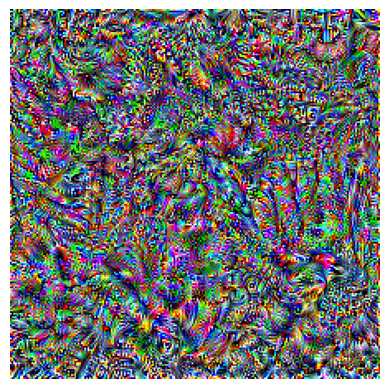

In [4]:
# Define the target class (class 8)
target_class = 8

# Initialize a random image (or use a noise image)
image = torch.randn(1, 3, 224, 224, requires_grad=True).to(device)
image_param = nn.Parameter(image)
# Set up an optimizer (e.g., Adam)
optimizer = optim.Adam([image_param], lr=2e-3)

# Optimization loop
for _ in range(500):
    logits = model(image_param)
    loss = -logits[0, target_class]  # Negative logit for class 8
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Normalize the image to [0, 1] range
    image_param.data = torch.clamp(image_param.data, min=0, max=1)

# Convert the optimized tensor to an image (e.g., using torchvision.transforms)
optimized_image = image_param.detach().cpu()  # Convert tensor to image

# Display the optimized image
plt.imshow(optimized_image[0].permute(1, 2, 0))
plt.axis('off')
plt.show()

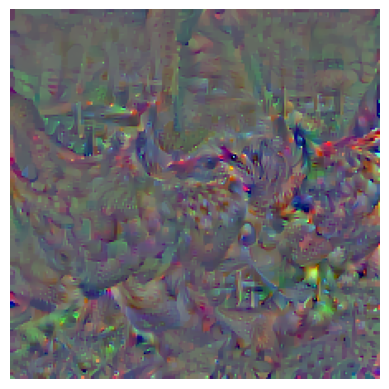

In [157]:
# Define the target class (class 8)
target_class = 8

# Initialize a random image (or use a noise image)
image = torch.randn(1, 3, 224, 224, requires_grad=True).to(device)
image_param = nn.Parameter(image)
# Set up an optimizer (e.g., Adam)
optimizer = optim.Adam([image_param], lr=2e-3)
lambda_tv = 0.02
# Optimization loop
for _ in range(700):
    logits = model(image_param)
    loss = -logits[0, target_class]  # Negative logit for class 8
        # Compute TV regularization term
    tv_term = torch.sum(torch.abs(image_param[:, :, :, :-1] - image_param[:, :, :, 1:])) + \
              torch.sum(torch.abs(image_param[:, :, :-1, :] - image_param[:, :, 1:, :]))

    # Total loss with TV regularization
    total_loss = loss + lambda_tv * tv_term
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    # Normalize the image to [0, 1] range
    image_param.data = torch.clamp(image_param.data, min=0, max=1)

# Convert the optimized tensor to an image (e.g., using torchvision.transforms)
optimized_image = image_param.detach().cpu()  # Convert tensor to image

# Display the optimized image
plt.imshow(optimized_image[0].permute(1, 2, 0))
plt.axis('off')
plt.show()

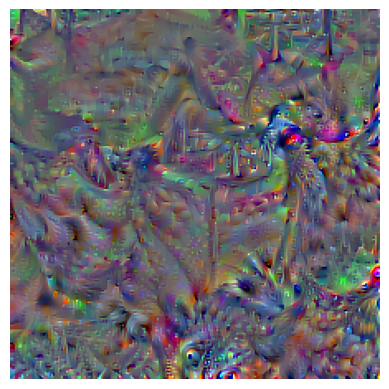

In [171]:
# Define the target class (class 8)
target_class = 8

# Initialize a random image (or use a noise image)
image = torch.randn(1, 3, 224, 224, requires_grad=True).to(device)
image_param = nn.Parameter(image)
# Set up an optimizer (e.g., Adam)
optimizer = optim.Adam([image_param], lr=1.5e-3)
lambda_tv = 0.015
# Optimization loop
for _ in range(1000):
    logits = model(image_param)
    loss = -logits[0, target_class]  # Negative logit for class 8
        # Compute TV regularization term
    tv_term = torch.sum(torch.abs(image_param[:, :, :, :-1] - image_param[:, :, :, 1:])) + \
              torch.sum(torch.abs(image_param[:, :, :-1, :] - image_param[:, :, 1:, :]))

    # Total loss with TV regularization
    total_loss = loss + lambda_tv * tv_term
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    # Normalize the image to [0, 1] range
    image_param.data = torch.clamp(image_param.data, min=0, max=1)

# Convert the optimized tensor to an image (e.g., using torchvision.transforms)
optimized_image = image_param.detach().cpu()  # Convert tensor to image

# Display the optimized image
plt.imshow(optimized_image[0].permute(1, 2, 0))
plt.axis('off')
plt.show()

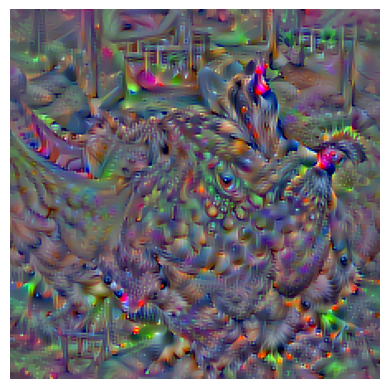

In [185]:
# Define the target class (class 8)
target_class = 8

# Initialize a random image (or use a noise image)
image = torch.randn(1, 3, 224, 224, requires_grad=True).to(device)
image_param = nn.Parameter(image)
# Set up an optimizer (e.g., Adam)
optimizer = optim.Adam([image_param], lr=2.3e-3)
max_shift = 15
lambda_tv = 0.008
# Optimization loop
for _ in range(750):
        # Generate random shift values
    shift_x = torch.randint(-max_shift, max_shift + 1, size=(1,))
    shift_y = torch.randint(-max_shift, max_shift + 1, size=(1,))

    # Apply the shift to the image
    shifted_image = torch.roll(image_param, shifts=(shift_x.item(), shift_y.item()), dims=(2, 3))

    logits = model(shifted_image)
    loss = -logits[0, target_class]  # Negative logit for class 8
        # Compute TV regularization term
    tv_term = torch.sum(torch.abs(image_param[:, :, :, :-1] - image_param[:, :, :, 1:])) + \
              torch.sum(torch.abs(image_param[:, :, :-1, :] - image_param[:, :, 1:, :]))

    # Total loss with TV regularization
    total_loss = loss + lambda_tv * tv_term
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    # Normalize the image to [0, 1] range
    image_param.data = torch.clamp(image_param.data, min=0, max=1)

# Convert the optimized tensor to an image (e.g., using torchvision.transforms)
optimized_image = image_param.detach().cpu()  # Convert tensor to image

# Display the optimized image
plt.imshow(optimized_image[0].permute(1, 2, 0))
plt.axis('off')
plt.show()

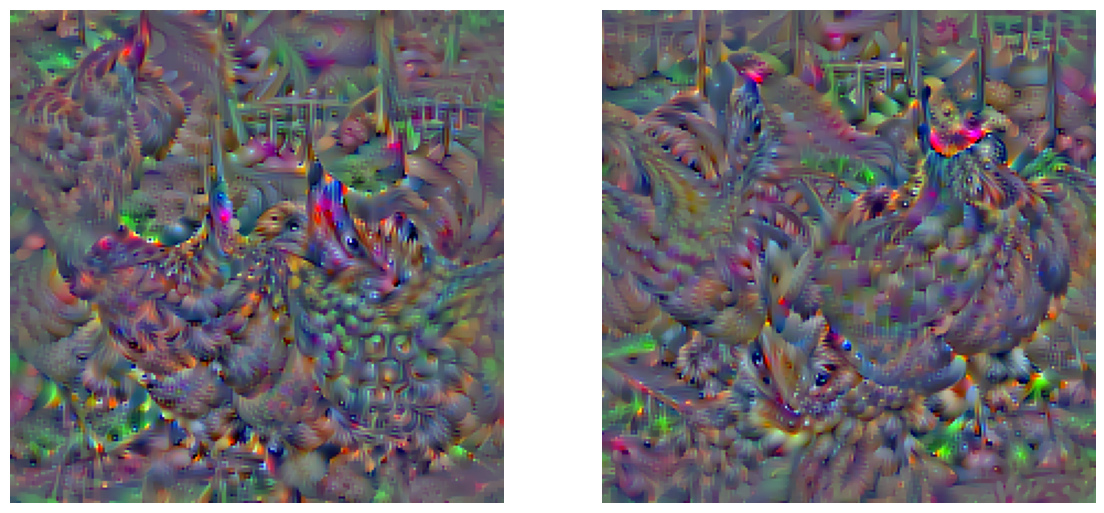

In [7]:
# Define the target class (class 8)
target_class = 8

# Initialize a random image (or use a noise image)

max_shift = 20
lambda_tv = 0.009
# Optimization loop
fig=plt.figure(figsize=(14,10))
for j in range(2):
    image = torch.randn(1, 3, 224, 224, requires_grad=True).to(device)
    image_param = nn.Parameter(image)
    # Set up an optimizer (e.g., Adam)
    optimizer = optim.Adam([image_param], lr=2.3e-3)
    for _ in range(750):
            # Generate random shift values
        shift_x = torch.randint(-max_shift, max_shift + 1, size=(1,))
        shift_y = torch.randint(-max_shift, max_shift + 1, size=(1,))

        # Apply the shift to the image
        shifted_image = torch.roll(image_param, shifts=(shift_x.item(), shift_y.item()), dims=(2, 3))

        logits = model(shifted_image)
        loss = -logits[0, target_class]  # Negative logit for class 8
            # Compute TV regularization term
        tv_term = torch.sum(torch.abs(image_param[:, :, :, :-1] - image_param[:, :, :, 1:])) + \
                torch.sum(torch.abs(image_param[:, :, :-1, :] - image_param[:, :, 1:, :]))

        # Total loss with TV regularization
        total_loss = loss + lambda_tv * tv_term
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        # Normalize the image to [0, 1] range
        image_param.data = torch.clamp(image_param.data, min=0, max=1)

    # Convert the optimized tensor to an image (e.g., using torchvision.transforms)
    optimized_image = image_param.detach().cpu()  # Convert tensor to image

    # Display the optimized image
    ax = fig.add_subplot(1, 2,j +1,xticks=[], yticks=[])
    plt.imshow(optimized_image[0].permute(1, 2, 0))
    plt.axis('off')
plt.show()